# Exploratory data analysis

## Import

In [3]:
import numpy as np 
import pandas as pd 
import json

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix, roc_auc_score, accuracy_score, f1_score
from sklearn.metrics import average_precision_score, precision_score

# import and instantiate TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# import and instantiate the Logistic Regression model
from sklearn.linear_model import LogisticRegression

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

In [5]:
RANDOM_SEED = 42

## Data

In [6]:
data = pd.read_json('../data/tickers_public_news.json')
data.head()

,text,release_points,technical_update_points,partnership_points,listing_points,security_points,from_the_project,not_from_the_project,staking
0,We'd like to remind everyone that our $BONDLY ...,0,29,0,0,100,100,0,0
1,I’d like to share the recently completed smart...,0,0,0,0,100,0,0,0
2,@LuckyBartlett We'll be releasing details soon...,0,100,0,0,0,0,0,2
3,Today we're taking the time to acknowledge our...,100,100,0,0,100,0,0,0
4,Business continuity has been a huge focus in o...,79,41,54,0,75,0,51,0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1212 entries, 0 to 1211
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   text                     1212 non-null   object
 1   release_points           1212 non-null   int64 
 2   technical_update_points  1212 non-null   int64 
 3   partnership_points       1212 non-null   int64 
 4   listing_points           1212 non-null   int64 
 5   security_points          1212 non-null   int64 
 6   from_the_project         1212 non-null   int64 
 7   not_from_the_project     1212 non-null   int64 
 8   staking                  1212 non-null   int64 
dtypes: int64(8), object(1)
memory usage: 85.3+ KB


Переведем таргеты в бинарное значение(1,0)

In [8]:
LABEL_COLUMNS = data.columns.tolist()[1:]
for target in LABEL_COLUMNS:
    data[target] = data[target] > 0
    data[target] = data[target].astype(int)

In [9]:
data[LABEL_COLUMNS].head()

,release_points,technical_update_points,partnership_points,listing_points,security_points,from_the_project,not_from_the_project,staking
0,0,1,0,0,1,1,0,0
1,0,0,0,0,1,0,0,0
2,0,1,0,0,0,0,0,1
3,1,1,0,0,1,0,0,0
4,1,1,1,0,1,0,1,0


In [10]:
len(data)

1212

In [11]:
data[LABEL_COLUMNS].sum()

release_points              87
technical_update_points     56
partnership_points          65
listing_points              58
security_points             37
from_the_project           127
not_from_the_project        84
staking                     46
dtype: int64

Text(0.5, 1.0, '# of label for each instance.')

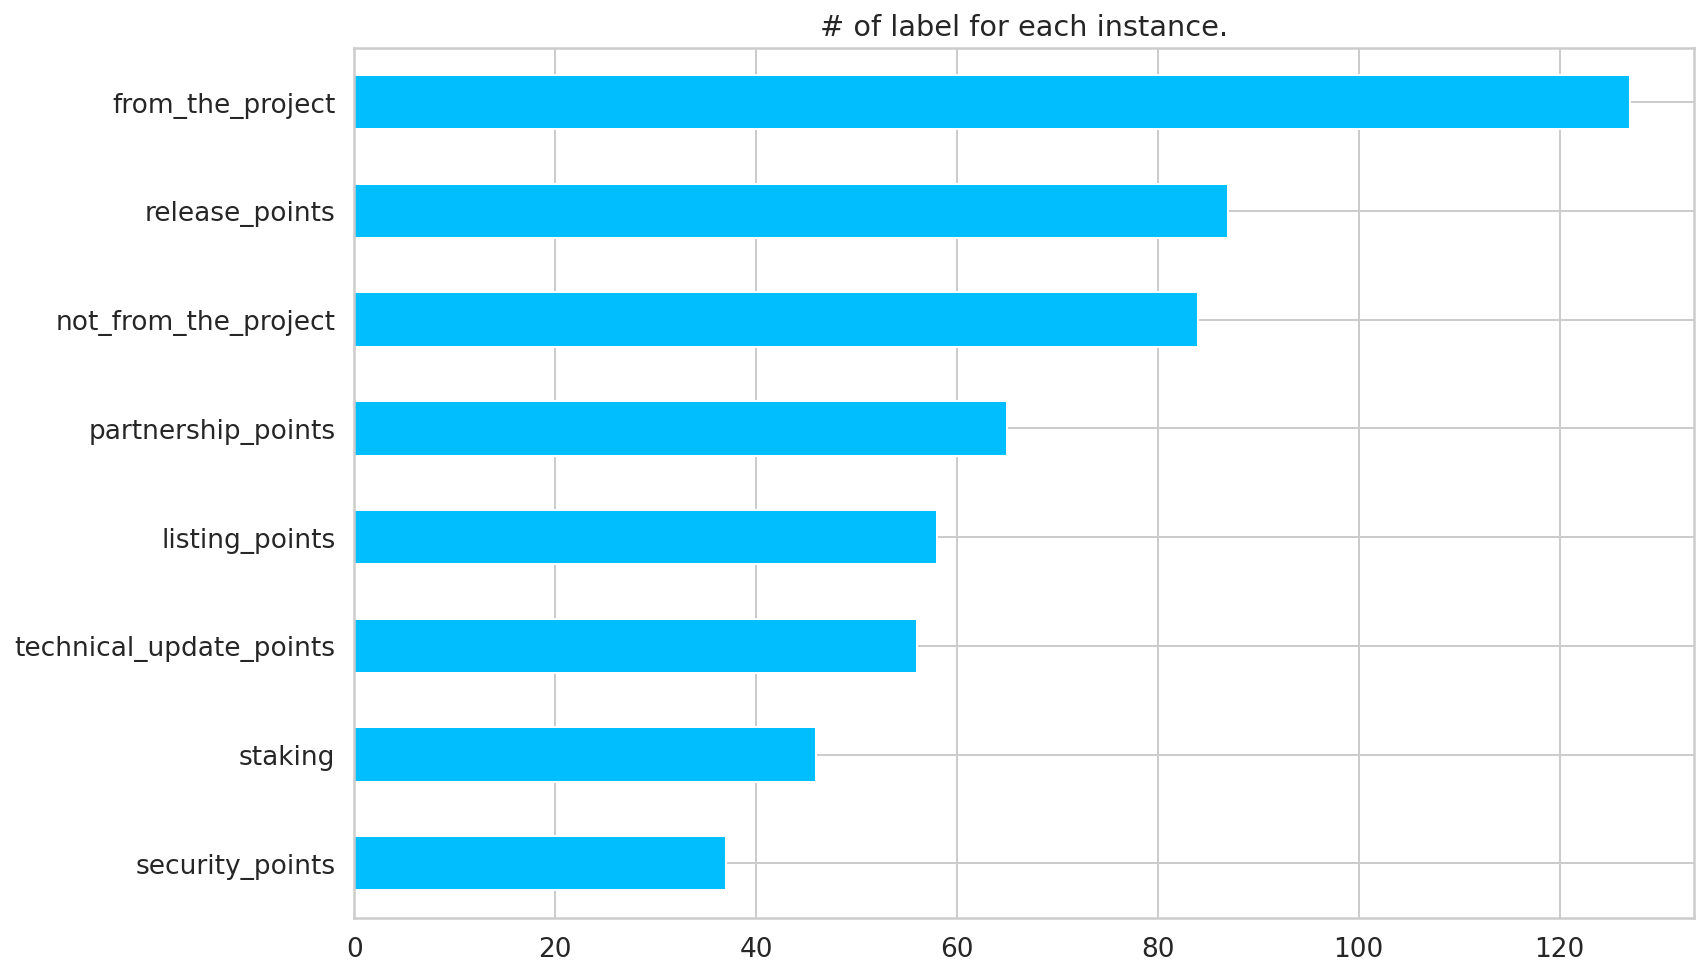

In [12]:
data[LABEL_COLUMNS].sum().sort_values().plot(kind="barh")
plt.title(f"# of label for each instance.")

In [13]:
data.to_csv('data.csv', index=False)

In [14]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
train_df.shape, test_df.shape

((969, 9), (243, 9))

# Baseline

In [15]:
benchmark = pd.DataFrame()

## Random Model
random predict

In [16]:
random_score = {}

for label in LABEL_COLUMNS:
    y_test = test_df[label].copy()
    predict_proba_test_X = np.random.random_sample(size=len(y_test))
    pred_test_X = predict_proba_test_X > 0.5

    random_score[label] = {}
    random_score[label]['accuracy'] = round(accuracy_score(y_test, pred_test_X),4)
    random_score[label]['precision'] = round(precision_score(y_test, pred_test_X),4)
    random_score[label]['average_precision'] = round(average_precision_score(y_test, predict_proba_test_X),4)
    random_score[label]['F1'] = round(f1_score(y_test, pred_test_X),4)
    random_score[label]['AUC'] = round(roc_auc_score(y_test, predict_proba_test_X),4)

In [17]:
benchmark['Random'] = pd.DataFrame(random_score).T.mean().round(4)
benchmark

,Random
accuracy,0.5046
precision,0.0673
average_precision,0.0864
F1,0.1174
AUC,0.5281


## LogisticRegression + TfidfVectorizer

In [18]:
import re
def clean_text(text):
    text = text.lower()
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [19]:
train_df['text'] = train_df['text'].map(lambda com : clean_text(com))
test_df['text'] = test_df['text'].map(lambda com : clean_text(com))

In [20]:
X = train_df.text
test_X = test_df.text
print(X.shape, test_X.shape)

(969,) (243,)


In [21]:
vect = TfidfVectorizer(max_features=5000, stop_words='english')

In [22]:
# learn the vocabulary in the training data, then use it to create a document-term matrix
X_dtm = vect.fit_transform(X)
# examine the document-term matrix created from X_train
X_dtm

<969x3513 sparse matrix of type '<class 'numpy.float64'>'
	with 9653 stored elements in Compressed Sparse Row format>

In [23]:
# transform the test data using the earlier fitted vocabulary, into a document-term matrix
test_X_dtm = vect.transform(test_X)
# examine the document-term matrix from X_test
test_X_dtm

<243x3513 sparse matrix of type '<class 'numpy.float64'>'
	with 1786 stored elements in Compressed Sparse Row format>

In [24]:
# create submission file
#submission_binary = pd.read_csv('../input/sample_submission.csv')
submission_binary = test_df[LABEL_COLUMNS].copy()
score = {}

for label in LABEL_COLUMNS:
    logreg = LogisticRegression(C=15.0)
    #print('####### Processing {} ##########'.format(label))
    y = train_df[label].copy()
    y_test = test_df[label].copy()
    # train the model using X_dtm & y
    logreg.fit(X_dtm, y)
    # compute the training accuracy
    #y_pred_X = logreg.predict(X_dtm)
    #print('Training accuracy is {}'.format(accuracy_score(y, y_pred_X)))
    # compute the predicted probabilities for X_test_dtm
    predict_proba_test_X = logreg.predict_proba(test_X_dtm)[:,1]
    pred_test_X = logreg.predict(test_X_dtm)

    score[label] = {}
    score[label]['accuracy'] = round(accuracy_score(y_test, pred_test_X),4)
    score[label]['precision'] = round(precision_score(y_test, pred_test_X),4)
    score[label]['average_precision'] = round(average_precision_score(y_test, predict_proba_test_X),4)
    score[label]['F1'] = round(f1_score(y_test, pred_test_X),4)
    score[label]['AUC'] = round(roc_auc_score(y_test, predict_proba_test_X),4)

    # print('accuracy: {}'.format(round(accuracy_score(y_test, pred_test_X),4)))
    # print('precision: {}'.format(round(precision_score(y_test, pred_test_X),4)))
    # print('average_precision: {}'.format(round(average_precision_score(y_test, pred_test_X),4)))
    # print('F1: {}'.format(round(f1_score(y_test, pred_test_X),4)))
    # print('AUC: {}'.format(round(roc_auc_score(y_test, predict_proba_test_X),4)))

    submission_binary[label] = predict_proba_test_X

/root/anaconda3/envs/kattana_p38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/anaconda3/envs/kattana_p38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
pd.DataFrame(score).T

,accuracy,precision,average_precision,F1,AUC
release_points,0.9465,1.0000,0.3320,0.1333,0.7960
technical_update_points,0.9794,1.0000,0.6701,0.5455,0.9309
partnership_points,0.9465,1.0000,0.4603,0.1333,0.8127
listing_points,0.9465,0.0000,0.1614,0.0000,0.8023
security_points,0.9588,1.0000,0.2636,0.1667,0.7637
from_the_project,0.8724,0.3333,0.3335,0.0606,0.7638
not_from_the_project,0.9342,0.0000,0.0684,0.0000,0.4851
staking,0.9506,1.0000,0.4842,0.1429,0.8548


In [26]:
pd.DataFrame(score).T.mean().round(4)

accuracy             0.9419
precision            0.6667
average_precision    0.3467
F1                   0.1478
AUC                  0.7762
dtype: float64

In [27]:
submission_binary

,release_points,technical_update_points,partnership_points,listing_points,security_points,from_the_project,not_from_the_project,staking
801,0.070286,0.032451,0.010515,0.021624,0.094651,0.302249,0.015396,0.027319
677,0.073050,0.043297,0.052368,0.008318,0.085560,0.079286,0.022942,0.011293
43,0.034220,0.037690,0.003196,0.009014,0.007361,0.008608,0.028795,0.001765
990,0.022048,0.013150,0.016317,0.004085,0.012392,0.017558,0.050359,0.082192
70,0.007869,0.017386,0.008763,0.058012,0.012870,0.132395,0.082239,0.005181
...,...,...,...,...,...,...,...,...
904,0.044042,0.008453,0.024535,0.006826,0.006489,0.018339,0.051812,0.005167
673,0.024318,0.018131,0.042102,0.014500,0.006438,0.320562,0.041936,0.008817
708,0.026811,0.033674,0.015417,0.040131,0.011940,0.048210,0.045805,0.012934
367,0.031644,0.009807,0.016359,0.012390,0.011645,0.041549,0.029205,0.008686


In [28]:
clf_report = classification_report(test_df[LABEL_COLUMNS], submission_binary[LABEL_COLUMNS] > 0.5, target_names=LABEL_COLUMNS)
#pickle.dump(clf_report, open('classification_report.txt','wb')) #save report
print(clf_report)

                         precision    recall  f1-score   support

         release_points       1.00      0.07      0.13        14
technical_update_points       1.00      0.38      0.55         8
     partnership_points       1.00      0.07      0.13        14
         listing_points       0.00      0.00      0.00        13
        security_points       1.00      0.09      0.17        11
       from_the_project       0.33      0.03      0.06        30
   not_from_the_project       0.00      0.00      0.00        16
                staking       1.00      0.08      0.14        13

              micro avg       0.80      0.07      0.12       119
              macro avg       0.67      0.09      0.15       119
           weighted avg       0.59      0.07      0.11       119
            samples avg       0.02      0.02      0.02       119



/root/anaconda3/envs/kattana_p38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/anaconda3/envs/kattana_p38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/anaconda3/envs/kattana_p38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
benchmark['LogisticRegression'] = pd.DataFrame(score).T.mean().round(4)
benchmark

,Random,LogisticRegression
accuracy,0.5046,0.9419
precision,0.0673,0.6667
average_precision,0.0864,0.3467
F1,0.1174,0.1478
AUC,0.5281,0.7762


## CatBoostClassifier

In [30]:
from catboost import CatBoostClassifier

In [31]:
submission_binary = test_df[LABEL_COLUMNS].copy()
score = {}

for label in LABEL_COLUMNS:
    model = CatBoostClassifier(verbose=False, random_state=RANDOM_SEED)
    #print('####### Processing {} ##########'.format(label))
    y = train_df[label].copy()
    y_test = test_df[label].copy()
    
    # train the model using X_dtm & y
    model.fit(X_dtm, y)

    predict_proba_test_X = model.predict_proba(test_X_dtm)[:,1]
    pred_test_X = model.predict(test_X_dtm)

    score[label] = {}
    score[label]['accuracy'] = round(accuracy_score(y_test, pred_test_X),4)
    score[label]['precision'] = round(precision_score(y_test, pred_test_X),4)
    score[label]['average_precision'] = round(average_precision_score(y_test, predict_proba_test_X),4)
    score[label]['F1'] = round(f1_score(y_test, pred_test_X),4)
    score[label]['AUC'] = round(roc_auc_score(y_test, predict_proba_test_X),4)

    submission_binary[label] = predict_proba_test_X

/root/anaconda3/envs/kattana_p38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/anaconda3/envs/kattana_p38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
benchmark['CatBoostClassifier'] = pd.DataFrame(score).T.mean().round(4)
benchmark

,Random,LogisticRegression,CatBoostClassifier
accuracy,0.5046,0.9419,0.9388
precision,0.0673,0.6667,0.3833
average_precision,0.0864,0.3467,0.2891
F1,0.1174,0.1478,0.1160
AUC,0.5281,0.7762,0.7521


## MLPClassifier

In [33]:
from sklearn.neural_network import MLPClassifier

In [34]:
submission_binary = test_df[LABEL_COLUMNS].copy()
score = {}

for label in tqdm(LABEL_COLUMNS):
    model = MLPClassifier(verbose=False, random_state=RANDOM_SEED)
    #print('####### Processing {} ##########'.format(label))
    y = train_df[label].copy()
    y_test = test_df[label].copy()
    
    # train the model using X_dtm & y
    model.fit(X_dtm, y)

    predict_proba_test_X = model.predict_proba(test_X_dtm)[:,1]
    pred_test_X = model.predict(test_X_dtm)

    score[label] = {}
    score[label]['accuracy'] = round(accuracy_score(y_test, pred_test_X),4)
    score[label]['precision'] = round(precision_score(y_test, pred_test_X),4)
    score[label]['average_precision'] = round(average_precision_score(y_test, predict_proba_test_X),4)
    score[label]['F1'] = round(f1_score(y_test, pred_test_X),4)
    score[label]['AUC'] = round(roc_auc_score(y_test, predict_proba_test_X),4)

    submission_binary[label] = predict_proba_test_X

 38%|███▊      | 3/8 [00:06<00:11,  2.21s/it]/root/anaconda3/envs/kattana_p38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 8/8 [00:18<00:00,  2.33s/it]


In [35]:
benchmark['MLPClassifier'] = pd.DataFrame(score).T.mean().round(4)
benchmark

,Random,LogisticRegression,CatBoostClassifier,MLPClassifier
accuracy,0.5046,0.9419,0.9388,0.9352
precision,0.0673,0.6667,0.3833,0.4133
average_precision,0.0864,0.3467,0.2891,0.2661
F1,0.1174,0.1478,0.1160,0.1698
AUC,0.5281,0.7762,0.7521,0.7062


# TF Bert Model

In [36]:
# Load Huggingface transformers
from transformers import TFBertModel,  BertConfig, BertTokenizerFast, TFAutoModel

# Then what you need from tensorflow.keras
from tensorflow.keras.layers import Input, Dropout, Dense, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

# And pandas for data import + sklearn because you allways need sklearn
import pandas as pd
import tensorflow as tf
import re
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix, roc_auc_score, accuracy_score, f1_score
from sklearn.metrics import average_precision_score, precision_score

# import and instantiate TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# import and instantiate the Logistic Regression model
from sklearn.linear_model import LogisticRegression

2022-03-17 07:17:02.763962: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-17 07:17:02.763984: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [123]:
# Name of the BERT model to use
model_name = 'bert-base-cased'

# Max length of tokens
max_length = 80

# Load transformers config and set output_hidden_states to False
config = BertConfig.from_pretrained(model_name)
#config.output_hidden_states = False

# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)
bert = TFAutoModel.from_pretrained(model_name)

input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
attention_mask = Input(shape=(max_length,), name='attention_mask', dtype='int32') 
inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}
nlp_model = bert.bert(inputs)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [124]:
train_sentences = train_df["text"].fillna("CVxTz").values
train_y = train_df[LABEL_COLUMNS].values

In [125]:
# Tokenize the input 
x = tokenizer(
    text=list(train_sentences),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [126]:
#  head
head = GlobalAveragePooling1D()(nlp_model[0])
#head = BatchNormalization()(head)
#head = Dense(256, activation="relu")(head)
#head = Dropout(0.5)(head)
head = Dense(len(LABEL_COLUMNS), activation='sigmoid', name='outputs')(head)

model = Model(inputs=inputs, outputs=head)
#model.layers[2].trainable = False

# Take a look at the model
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, 80)]         0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 80)]         0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['attention_mask[0][0]',         
                                thPoolingAndCrossAt               'input_ids[0][0]']              
                                tentions(last_hidde                                               
                                n_state=(None, 80,                                          

In [137]:
optimizer = Adam(learning_rate=1e-5,)
model.compile(loss='binary_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy', tf.keras.metrics.AUC()])

In [138]:
model.load_weights('bert_model_weights.h5')

In [151]:
history = model.fit(
    x={'input_ids': x['input_ids'], 'attention_mask': x['attention_mask']},
    y={'outputs': train_y},
    validation_split=0.0,
    batch_size=64,
    epochs=5)

Epoch 1/4
16/16 [==============================] - 115s 7s/step - loss: 0.1309 - accuracy: 0.5655 - auc_8: 0.8606
Epoch 2/4
16/16 [==============================] - 116s 7s/step - loss: 0.1276 - accuracy: 0.5986 - auc_8: 0.8631
Epoch 3/4
16/16 [==============================] - 114s 7s/step - loss: 0.1219 - accuracy: 0.6120 - auc_8: 0.8732
Epoch 4/4
16/16 [==============================] - 116s 7s/step - loss: 0.1156 - accuracy: 0.5934 - auc_8: 0.8834


In [156]:
model.save_weights('bert_model_weights_v2.h5', )

In [140]:
test_sentences = test_df["text"].fillna("CVxTz").values
test_y = test_df[LABEL_COLUMNS].values

In [152]:
test_x = tokenizer(
    text=list(test_sentences),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [153]:
predictions = model.predict(x={'input_ids': test_x['input_ids'], 'attention_mask': test_x['attention_mask']},batch_size=64)
predictions_probes = pd.DataFrame(predictions)
predictions_probes.columns = LABEL_COLUMNS

In [154]:
pred_bools = [pl>0.50 for pl in predictions] #boolean output after thresholding

# Print and save classification report
print('Test F1 Accuracy: ', f1_score(test_y, pred_bools, average='micro'))
print('Test Flat Accuracy: ', accuracy_score(test_y, pred_bools),'\n')
clf_report = classification_report(test_y,pred_bools,target_names=LABEL_COLUMNS)
#pickle.dump(clf_report, open('classification_report.txt','wb')) #save report
print(clf_report)

Test F1 Accuracy:  0.2887700534759358
Test Flat Accuracy:  0.654320987654321 

                         precision    recall  f1-score   support

         release_points       0.50      0.29      0.36        14
technical_update_points       0.50      0.50      0.50         8
     partnership_points       0.75      0.21      0.33        14
         listing_points       0.23      0.23      0.23        13
        security_points       1.00      0.09      0.17        11
       from_the_project       0.37      0.33      0.35        30
   not_from_the_project       0.20      0.06      0.10        16
                staking       0.50      0.08      0.13        13

              micro avg       0.40      0.23      0.29       119
              macro avg       0.51      0.22      0.27       119
           weighted avg       0.47      0.23      0.27       119
            samples avg       0.08      0.06      0.07       119



/root/anaconda3/envs/kattana_p38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/anaconda3/envs/kattana_p38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [161]:
random_score = {}

for label in LABEL_COLUMNS:
    y_test = test_df[label].copy()
    predict_proba_test_X = predictions_probes[label]
    pred_test_X = predict_proba_test_X > 0.5

    random_score[label] = {}
    random_score[label]['accuracy'] = round(accuracy_score(y_test, pred_test_X),4)
    random_score[label]['precision'] = round(precision_score(y_test, pred_test_X),4)
    random_score[label]['average_precision'] = round(average_precision_score(y_test, predict_proba_test_X),4)
    random_score[label]['F1'] = round(f1_score(y_test, pred_test_X),4)
    random_score[label]['AUC'] = round(roc_auc_score(y_test, predict_proba_test_X),4)
    
benchmark['NN_Bert'] = pd.DataFrame(random_score).T.mean().round(4)
benchmark

,Random,LogisticRegression,CatBoostClassifier,MLPClassifier,NN_Bert
accuracy,0.5046,0.9419,0.9388,0.9352,0.9316
precision,0.0673,0.6667,0.3833,0.4133,0.5064
average_precision,0.0864,0.3467,0.2891,0.2661,0.3109
F1,0.1174,0.1478,0.1160,0.1698,0.2717
AUC,0.5281,0.7762,0.7521,0.7062,0.7434
